In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
import qim3d
import os

%matplotlib inline

In [3]:
# Define function for getting dataset path from string
def get_dataset_path(name: str, datasets):
    assert name in datasets, 'Dataset name must be ' + ' or '.join(datasets)
    dataset_idx = datasets.index(name)
    if os.name == 'nt':
        datasets_path = [
            '//home.cc.dtu.dk/3dimage/projects/2023_STUDIOS_SD/analysis/data/Belialev2020/side',
            '//home.cc.dtu.dk/3dimage/projects/2023_STUDIOS_SD/analysis/data/Gaudez2022/3d',
            '//home.cc.dtu.dk/3dimage/projects/2023_STUDIOS_SD/analysis/data/Guo2023/2d/',
            '//home.cc.dtu.dk/3dimage/projects/2023_STUDIOS_SD/analysis/data/Stan2020/2d',
            '//home.cc.dtu.dk/3dimage/projects/2023_STUDIOS_SD/analysis/data/Reichardt2021/2d',
            '//home.cc.dtu.dk/3dimage/projects/2023_STUDIOS_SD/analysis/data/TestCircles/2d_binary'
        ]
    else:
        datasets_path = [
            '/dtu/3d-imaging-center/projects/2023_STUDIOS_SD/analysis/data/Belialev2020/side',
            '/dtu/3d-imaging-center/projects/2023_STUDIOS_SD/analysis/data/Gaudez2022/3d',
            '/dtu/3d-imaging-center/projects/2023_STUDIOS_SD/analysis/data/Guo2023/2d/',
            '/dtu/3d-imaging-center/projects/2023_STUDIOS_SD/analysis/data/Stan2020/2d',
            '/dtu/3d-imaging-center/projects/2023_STUDIOS_SD/analysis/data/Reichardt2021/2d',
            '/dtu/3d-imaging-center/projects/2023_STUDIOS_SD/analysis/data/TestCircles/2d_binary'
        ]

    return datasets_path[dataset_idx]

### Datasets

In [4]:
datasets = ['belialev2020_side', 'gaudez2022_3d', 'guo2023_2d', 'stan2020_2d', 'reichardt2021_2d', 'testcircles_2dbinary']
dataset = datasets[3] 
root = get_dataset_path(dataset,datasets)

# should not use gaudez2022: 3d image
# reichardt2021: multiclass segmentation

### Model and Augmentation

In [5]:
# defining model
my_model = qim3d.models.UNet(size = 'medium', dropout = 0.25)
# defining augmentation
my_aug = qim3d.utils.Augmentation(resize = 'crop', transform_train = 'light')

### Loading the data

In [6]:
# level of logging
qim3d.io.logger.level('info')

# datasets and dataloaders
train_set, val_set, test_set = qim3d.utils.prepare_datasets(path = root, val_fraction = 0.3,
                                                            model = my_model , augmentation = my_aug)

train_loader, val_loader, test_loader = qim3d.utils.prepare_dataloaders(train_set, val_set,
                                                                        test_set, batch_size = 6)

The image size doesn't match the Unet model's depth. The image is changed with 'crop', from (852, 852) to (832, 832).


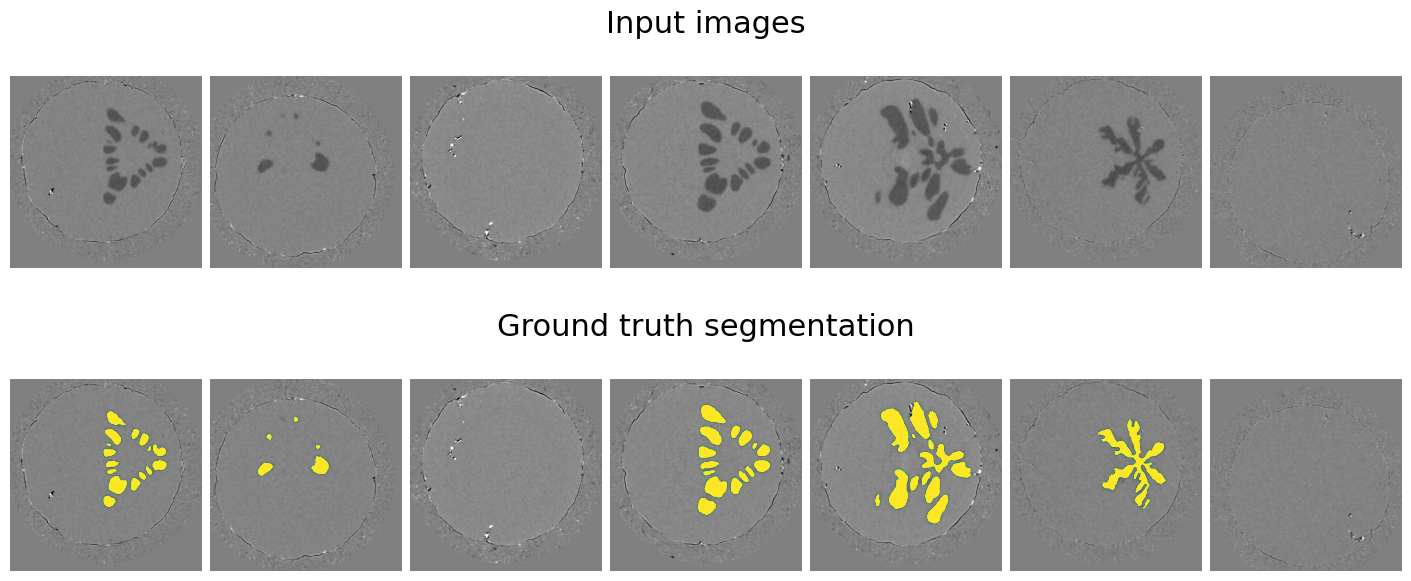

In [7]:
qim3d.viz.grid_overview(train_set,alpha = 1)

In [8]:
# Summary of model
model_s = qim3d.utils.model_summary(train_loader,my_model)
print(model_s)

Layer (type:depth-idx)                                                                Output Shape              Param #
UNet                                                                                  [6, 1, 832, 832]          --
├─UNet: 1-1                                                                           [6, 1, 832, 832]          --
│    └─Sequential: 2-1                                                                [6, 1, 832, 832]          --
│    │    └─Convolution: 3-1                                                          [6, 64, 416, 416]         --
│    │    │    └─Conv2d: 4-1                                                          [6, 64, 416, 416]         640
│    │    │    └─ADN: 4-2                                                             [6, 64, 416, 416]         --
│    │    │    │    └─InstanceNorm2d: 5-1                                             [6, 64, 416, 416]         --
│    │    │    │    └─Dropout: 5-2                                        

### Hyperparameters and training

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch   0, train loss: 0.7937, val loss: 0.5800


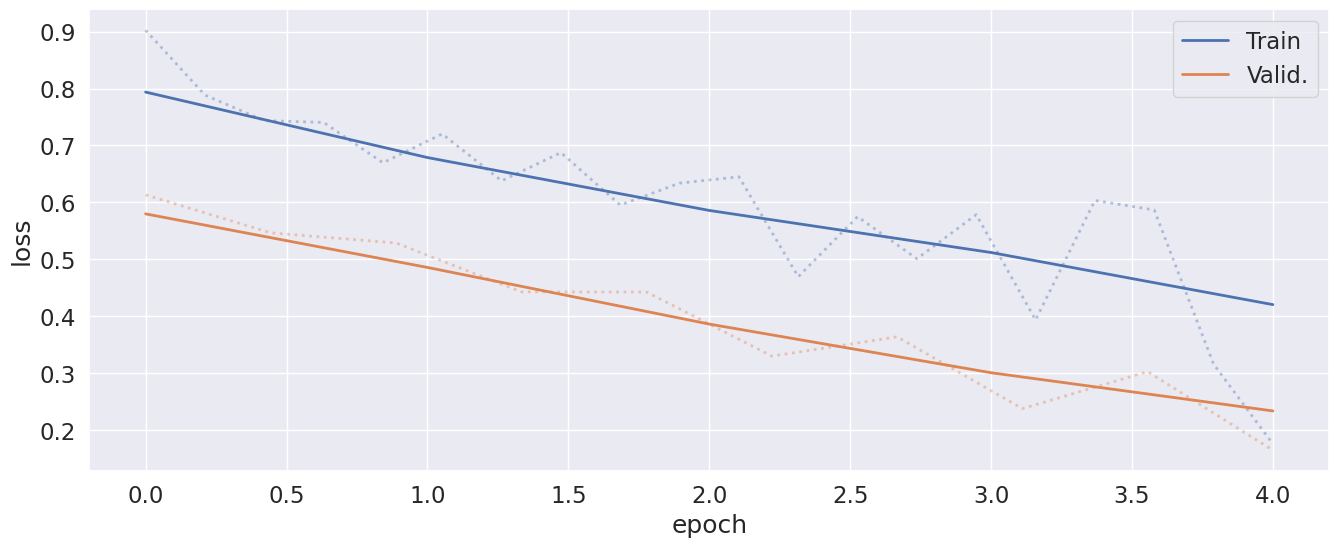

In [9]:
# model hyperparameters
my_hyperparameters = qim3d.models.Hyperparameters(my_model, n_epochs=5,
                                                  learning_rate = 5e-3, loss_function='DiceCE',weight_decay=1e-3)

# training model
qim3d.utils.train_model(my_model, my_hyperparameters, train_loader, val_loader, plot=True)

### Plotting

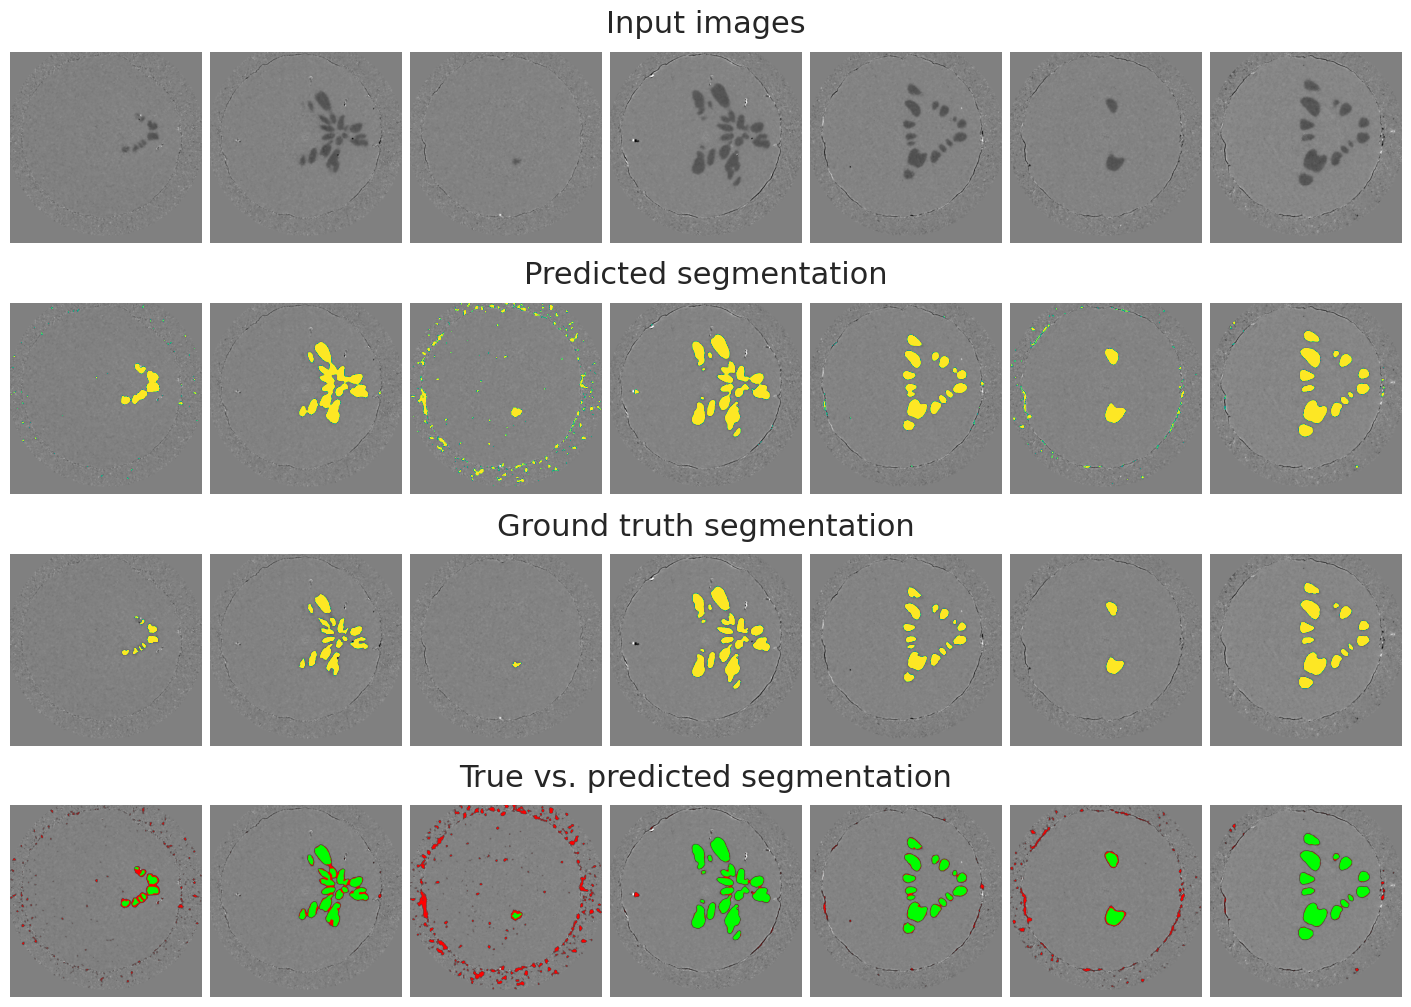

In [10]:
in_targ_preds_test = qim3d.utils.inference(test_set,my_model)
qim3d.viz.grid_pred(in_targ_preds_test,alpha=1)